In [1]:
using Symbolics
using LinearAlgebra
using Latexify
using Plots

In [411]:
include("inversion_ext.jl")

5×5 Matrix{Rational{Int64}}:
 1//1  0//1  0//1  0//1  0//1
 0//1  1//1  0//1  0//1  0//1
 0//1  0//1  3//4  0//1  1//4
 0//1  0//1  0//1  1//2  0//1
 0//1  0//1  1//4  0//1  3//4

In [412]:
#flu_to_abs([-1.;0.5;0.0;0.1;0.2])

## Fluídos Conformes

Código para testear la estabilidad alrededor de una solución de equilibrio.

Las ecuaciones son:

$(\zeta^a, \zeta^{ab})$ -> $f^j = (\mu, v, x_i)$ -> $(-1,0,0,0,0)$

$$
\partial_t c^j = \partial_i F^{ij}(f) + I^j(f) = \frac{\partial F^{ij}}{\partial f^k}\partial_i f^k
$$

$$
c^j = C^j(f) = (e, S, c_i)
$$

Lo que hacemos es tomar el jacobiano del flujo,

$\frac{\partial F^i}{\partial f^j}$ donde $f^j$ son las variables no conservativas para las cuales tenemos las expresiones del Flujo. 
A estas las multiplicamos por $[\frac{\partial c^k}{\partial f^j}]^{-1}$.
Tenemos así 

$$
PC^{il}{}_j := \frac{\partial F^{il}}{\partial c^j} = \frac{\partial F^{il}}{\partial f^k}\frac{\partial f^k}{\partial c^j}.
$$

Evaluamos todo en el vector $(-1,0,0,0,0)$ o sea estamos en el frame con velocidad cero y todas las variables fuera de equilibrio también cero.

Lo mismo hacemos con la fuente. 

$$
IIC^i{}_j = \frac{\partial I^i}{\partial f^k} \frac{\partial f^k}{\partial c^j}
$$

Tenemos así el sistema linearizado en el punto de equilibrio en las variables conservativas. Multiplicamos $P^i{}_j$ por un número complejo cualquiera y para todos ellos los autovalores debieran tener parte real negativa o nula. Pero no es así...


Alternativamente podemos diferenciar $c^i$ con respecto a los $f^j$ para obtener,

$$
\partial_t c^j = \frac{\partial c^j}{\partial f^i} \partial_t f^i
$$

y por lo tanto,

$$
\partial_t f^i = \frac{\partial c^j}{\partial f^i}^{-1} \frac{\partial F^{lj}}{\partial f^k}\partial_l f^k := PF^i{}_k\partial_l f^k
$$

A las que simplemente sumamos el término $\frac{\partial c^j}{\partial f^i}^{-1}\frac{\partial I^j}{\partial f^k}$ para tener el sistema linearizado con respecto a las $f^i$.


Sistema mixto, supongamos ahora que tenemos el sistema escrito como:

$$
\frac{\partial c^i}{\partial t} = \partial_x Fl^i(f^k(c^j), c^k) = 
\frac{\partial Fl^i}{\partial c^k} \partial_x c^k 
+ \frac{\partial Fl^i}{\partial f^l} \frac{\partial f^l}{\partial c^k} \partial_x c^k
= (\frac{\partial Fl^i}{\partial c^k}  
+ \frac{\partial Fl^i}{\partial f^l} \frac{\partial f^l}{\partial c^k}) \partial_x c^k
$$

Si vemos la teoría, $\frac{\partial Fl^i(f^j)}{\partial a^l}$ (donde $a^l$ son las variables abstractas) debería ser simétrico. 
Para chequear esto debemos hacer:

$$
\frac{\partial Fl^i(f^j)}{\partial f^l} = \frac{\partial Fl^i(c^j,f^j)}{\partial f^l} + \frac{\partial Fl^i(c^j,f^j)}{\partial c^k} \frac{\partial c^k}{\partial f^l}
$$

Pero en realidad lo debemos expresar en término de las variables abstractas, que no son las f...
las llamaremos $a$.

Por lo que debemos mirar a 

$$
\frac{\partial Fl^i(f^j)}{\partial f^l}\frac{\partial f^l}{\partial a^p} = [\frac{\partial Fl^i(c^j,f^j)}{\partial f^l} + \frac{\partial Fl^i(c^j,f^j)}{\partial c^k} \frac{\partial c^k}{\partial f^l}]\frac{\partial f^l}{\partial a^p}
$$

In [413]:
function Flux_imp!(Fl,flu,con,p)
    χ = p
    μ = flu[1]  # esto es -μ
    #μ = view(flu,1)
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    ν = flu[3]
    r1 = flu[4]
    t11 = flu[5]
    χ₀ = χ[1]
    χ₁ = χ[2]
    χ₂ = χ[3]
    γ = (1 - v^2)^(-1//2)
    
    T11_0 = -8χ₀*T^4*(γ^2*v^2+1//4)
    T11_1 = χ₁*(-80//3*T^8*ν*(γ^2*v^2+1//4)  - 20*T^7*r1*γ*v  - 2*T^6*t11)
    T11_2 = χ₂*T^8*(ν^2*(-560*T^4*(γ^2*v^2 + 1//4)) - ν*r1*T^3*1120*γ*v - ν*t11*T^2*112
                    + r1^2*T^2*(-315v^2-217)
                    + r1*t11*T*336*γ*v*(v^2-1)
                    + t11^2*(-111 - 78v^2 + 189v^4)/4)
    A111_1 = -3χ₁*γ*v*T^5*(2γ^2*v^2+1)
    A111_2 = - 12χ₂*T^8*(v*T*10*γ*(2γ^2*v^2+1)*ν + 3*(1+6γ^2*v^2)*r1 + 3v*γ*t11/T)

    Fl[1] = con[2] 
    Fl[2] = T11_0 + T11_1 + T11_2
    Fl[3] = con[4]
    Fl[4] = con[5] 
    Fl[5] = A111_1 + A111_2
    return -Fl[:]
end



Flux_imp! (generic function with 1 method)

In [414]:
@variables f[1:5], c[1:5], Fl[1:5], p[1:3], r[1:5]

JFS_f = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),f);
JFS_c = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),c);
JF_f_exp = Symbolics.build_function(JFS_f, Fl, f, c, p);
JF_c_exp = Symbolics.build_function(JFS_c, Fl, f, c, p);
JFac_f = eval(JF_f_exp[1]);
JFac_c = eval(JF_c_exp[1]);
#JF_f_exp[2]

In [426]:
re = zeros(5)
fl = zeros(5)
flu=2.0*[-1.;0.1;1.0;0.0;0.0];
par_f = [1,0.0,1.000001]
con = F_alt!(re,flu,zeros(5), par_f);
JFac_f(fl,flu,con,par_f)
JFac_c(fl,flu,con,par_f)
Jf2c(r,flu,con,par_f) # Notar que para v \to 1 la matríz se hace singular.
Jf2c(r,flu,con,par_f)*inv(Jf2a_exp1(flu))*S
#[Jf2c(r,flu,con,par_f) inv(Jf2a_exp1(flu))]
#inv(Jf2a_exp1(flu))


5×5 Matrix{Float64}:
 -224.539   -76.9186  -62.5572   -25.98     -25.8719
  -56.3839  -74.0733  -19.485    -23.779    -13.1655
  -61.5417  -23.3334   -9.99839   -4.30908   -4.22489
  -23.3334  -24.7917   -4.30908   -4.22489   -2.72137
  -24.7917  -14.5833   -4.22489   -2.72137   -2.78151

The above is: $\frac{\partial F^{0A}}{\partial \xi_B}$ row is B, and column is A $F^{0A} = (T00,T01,A000,A001,A011)$

In [287]:
PC(r,fl,flu,c,p) =  JFac_f(fl,flu,con,p)*inv(Jf2c(r,flu,con,p)) + JFac_c(fl,con,flu,p) #var conserv
PF(r,fl,flu,c,p) = inv(Jf2c(r,flu,con,p))*(JFac_f(fl,flu,con,p) + JFac_c(fl,con,flu,p)*Jf2c(r,flu,con,p)) #var fluid

PF (generic function with 1 method)

In [288]:
(JFac_f(fl,flu,con,par_f) + JFac_c(fl,con,flu,par_f)*Jf2c(r,flu,con,par_f))*inv(Jf2a_exp1(flu))*S

5×5 Matrix{Float64}:
 11.9912   26.644    17.4569  35.8514  11.3424
 24.7679    7.51538  28.8514  11.3424  19.7066
  3.96572  34.5966   21.7929  34.0987  13.2531
  1.95011   8.89501  34.0987  13.2531  21.0636
  2.43036  21.243    13.2531  21.0636   9.53755

In [284]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.;0;0;0.];
par_f = [1.,-0.,0.06]
con = F_alt!(re,flu,zeros(5), par_f);
H = [3/2 0 0 0 0;
     0 2 0 0 0;
     0 0 2 0 0;
     0 0 0 3/2 0;
     0 0 0 0 0.3/1.3333333]*PF(re,fl,flu,c,par_f)

5×5 Matrix{Float64}:
  0.0  -1.0   0.0   0.0   0.0
 -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0  -1.0   0.0  -0.3
  0.0   0.0   0.0  -0.3   0.0

In [285]:
H = [3/2 0 0 0 0;
     0 2 0 0 0;
     0 0 2 0 0;
     0 0 0 3/2 0;
     0 0 0 0 0.3/1.3333333]
H*PF(re,fl,flu,c,par_f)

5×5 Matrix{Float64}:
  0.0  -1.0   0.0   0.0   0.0
 -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0  -1.0   0.0  -0.3
  0.0   0.0   0.0  -0.3   0.0

In [76]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.0;0.0;0.0;0.0];
par_f = [-1.,0.,2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(PC(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414833
 -0.5773502691896256
  0.0
  0.5773502691896258
  0.7745966692414834

In [77]:
1/0.7745966692414834^2
1/sqrt(5/3)

0.7745966692414834

In [78]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.0;0.;0.0;0.];
par_f = [1.,-1.,2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(PF(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414831
 -0.5773502691896253
 -7.003006805668652e-17
  0.5773502691896256
  0.7745966692414833

In [81]:
re = zeros(5)
fl = zeros(5)
N = 1000
flu=[-1.;0.0;0.;0.0;0.00];
par_f = [1.,0.,1.]
#par_f = [-1,-0.5,-20]
E = zeros(5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/(N-1)/1.01
    flu[2] = v[i]
    re = zeros(5)
    fl = zeros(5)
    con = F_alt!(zeros(5),flu,zeros(5), par_f);
    E[:,i]=eigvals(PC(zeros(5),zeros(5),flu,con,par_f))
    if any(E[:,i].>1.)
        #println(E[:,i], v[i])
    end
end

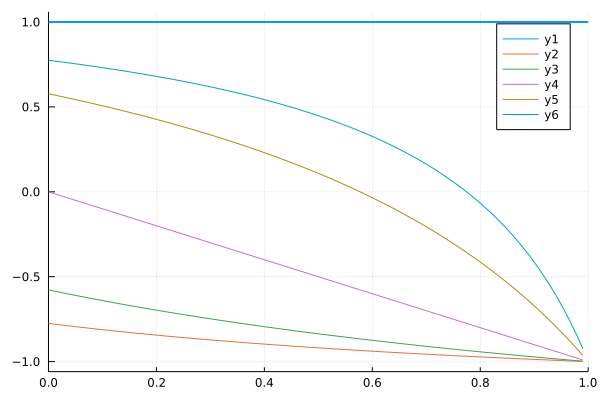

In [82]:
one(x)=1
plot(one,xlim=(0,1),legend=:topright, lw=2)
plot!(v,E[1,:])
plot!(v,E[2,:]
#,legend=:topright
)
plot!(v,E[3,:])
plot!(v,E[4,:])
plot!(v,E[5,:])

In [83]:
Eu(flu,con,par_f) = PC(re,fl,flu,con,par_f)[1:2,1:2]

Eu (generic function with 1 method)

In [84]:
N = 100
par_f = [-1.,-0.01,-0.001]
Eul = zeros(2,N)
flu = [-1; 0; 0.1; 0.0; 0.0]
for i in 1:N
    v = (i-1)/N
    flu[2] = v
    re = zeros(5)
    con = F_alt!(re,flu,zeros(5), par_f);
    #Eul[:,i]=eigvals(Eu(flu,[con[1];con[2];0;0;0],par_f))
    Eul[:,i]=eigvals(Eu(flu,con,par_f))
end

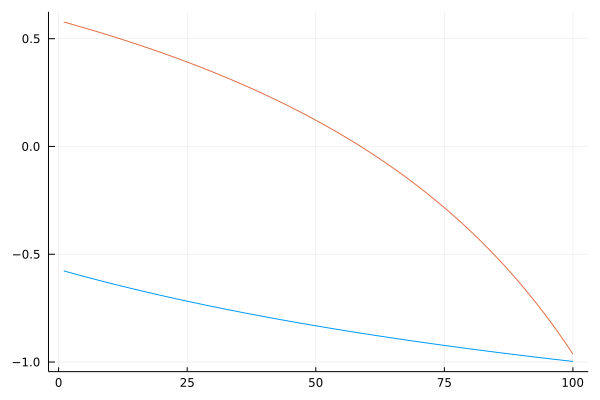

In [85]:
plot(Eul[1,:],
    label=false)
plot!(Eul[2,:],
    label=false)

## Hacemos lo mismo para la fuente.

In [86]:
function Is(flu, χ, ξ)
    #(χ, ξ) = par 
    μ = flu[1] 
    #χ₀= χ[1]
    #χ₁= -χ[2] # lo hacemos positivo
    #κ = ξ[1]*χ₀ # χ₀*ξ[1]/χ₁^2 # OK 
    #λ = ξ[2]*χ₀ #χ₀*ξ[2]/χ₁^2  # OK
    #η = ξ[3]*χ₀ #χ₀*ξ[3]/χ₁^2
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    γ = (1. - v^2)^(-1//2)
    x1 = γ*T*flu[3]
    x2 = flu[4]
    x3 = γ/T*flu[5]
    return [0.;
            0.;
            (-(γ^2    -1//4)*x1*ξ[1]         + 2γ*v*x2*ξ[2]/T      - μ*v^2*x3*ξ[3])/μ^5;
            (-(γ^2*v  + 0  )*x1*ξ[1]         + γ*(v^2+1)*x2*ξ[2]/T - μ*v*x3*ξ[3])/μ^5;
            (-(γ^2*v^2+1//4)*x1*ξ[1]         + 2γ*v*x2*ξ[2]/T      - μ*x3*ξ[3])/μ^5;
            ]
end

Is (generic function with 1 method)

In [87]:
@variables q[1:3]  
Is(f,p,q);

In [88]:
JSS = Symbolics.jacobian(Is(f,p,q),f);

In [89]:
JS_exp = Symbolics.build_function(JSS, f, p,q);

In [90]:
JSac = eval(JS_exp[1]);

In [91]:
II(r,flu,con,p,q) = JSac(flu,p,q)*inv(Jf2c(r,flu,con,p))

II (generic function with 1 method)

In [92]:
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
con = F_alt!(zeros(5),flu,zeros(5), par_f);
par_s = 100π*[10; -15; -1]
eigvals(II(zeros(5),flu,con,par_f,par_s))

5-element Vector{Float64}:
 -26.179938779914945
  -8.726646259971648
  -6.544984694978737
   0.0
   0.0

In [93]:
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
con = F_alt!(zeros(5),flu,zeros(5), par_f);
par_s = 100π*[10; -15; -1]
real.(eigvals(II(zeros(5),flu,con,par_f,par_s)))

5-element Vector{Float64}:
 -26.179938779914945
  -8.726646259971648
  -6.544984694978737
   0.0
   0.0

In [94]:
N = 100
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
par_s = 100π*[10; -15; -1] #[-1/15/π, 1/π, -1/π] #(κ,λ,η)
ET = fill(1.0+0*im,5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu=[-1.;0.0;0.0;0.0;0.00];
    flu[2] = v[i]
    con = F_alt!(zeros(5),flu,zeros(5), par_f);
    ET[:,i]=eigvals(1.0*im * PC(zeros(5),fl,flu,con,par_f) - 1.0*II(zeros(5),flu,con,par_f,par_s))
#    if any(imag.(ET[:,i]).>1.)
        #println(imag.(ET[:,i]), v[i])
#    end
#    if any(real.(ET[:,i]).>0.)
        #println(real.(ET[:,i]), v[i])
#    end
end
par_s

3-element Vector{Float64}:
  3141.5926535897934
 -4712.38898038469
  -314.1592653589793

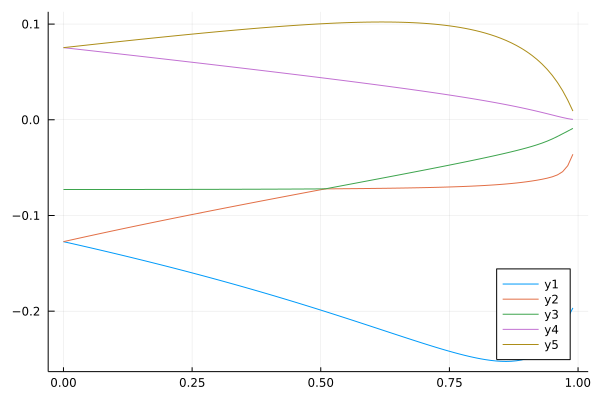

In [95]:
plot(legend=:bottomright)
for j in 1:5
    plot!(v,real.(ET[j,:])
        #,ylims=(-0.01,0.001)
    )
end
current()

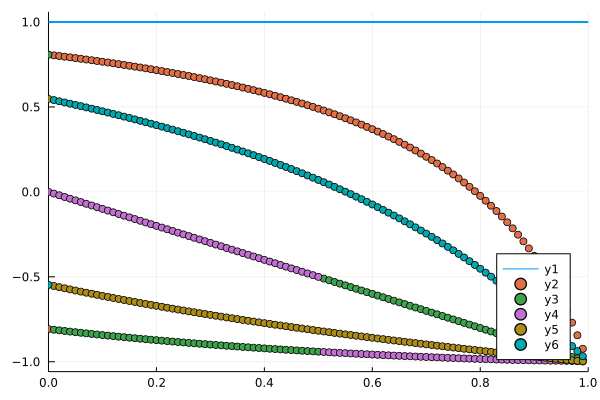

In [96]:
#one(x)=1
plot(one,xlim=(0,1),legend=:bottomright, lw=2)
for i in 1:5
    scatter!(v,imag.(ET[i,:]))
end
current()

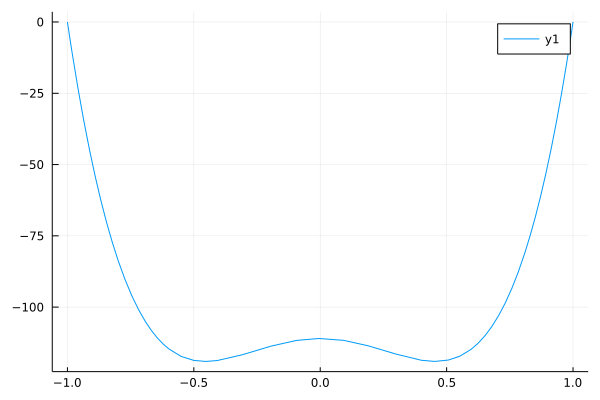

In [97]:
# el término enfrente de t11^2 Notar que va a cero cuando v \to \pm 1
lt11_2(vv)=(-111 + 126vv^2 - 15vv^4 - 204vv^2*(1-vv^2))#/(1-vv^2)
plot(lt11_2, -1,1)

In [98]:
lr1_2(vv) = -364*vv^2-217+49vv^2
plot(lr1,-1,1)

LoadError: UndefVarError: lr1 not defined

$$
\frac{\partial^3 \chi}{\partial \zeta^a \partial \zeta^A \partial \zeta^B}\nabla_a \zeta^B = I^{A}
$$

$$
\nabla_a(\frac{\partial^2 \chi}{\partial \zeta^a \partial \zeta^A}) = \nabla_a F^{aA} = I^A
$$

$$
T^{ab} = \frac{\partial \chi^a}{\partial \xi^b} = 8\chi_0(\frac{\xi^a \xi^b}{\mu^3} - \frac{g^{ab}}{4\mu^2})
$$

$$
c^a = (T^0{}_0, T^0{}_1) = (\frac{\partial \chi^0}{\partial \xi^0}, \frac{\partial \chi^0}{\partial \xi^1}) \;\;\;\; \mbox{estas son las cantidades conservadas, con el indice abajo!}
$$

$$
\frac{\partial T^{ab}}{\partial \xi^c} = \frac{\partial \chi^a}{\partial \xi^b \partial \xi^c} = 8\chi_0(\frac{3 \xi^{(a}g^{bc)}}{\mu^3} - \frac{6\xi^a\xi^b\xi^c}{\mu^4})
$$

$$
\frac{\partial c^a}{\partial \xi^b} = \left(\begin{array}{c,c}
                                            \frac{\partial \chi^0}{\partial \xi^0 \partial \xi^0} & \frac{\partial \chi^0}{\partial \xi^0 \partial \xi^1} \\
                                   \frac{\partial \chi^0}{\partial \xi^1 \partial \xi^0} & \frac{\partial \chi^1}{\partial \xi^1 \partial \xi^0}
                                   \end{array}
                                   \right)
= 8\chi_0 T^5\gamma \left(\begin{array}{c,c}
    3(1-2\gamma^2) & -6 \gamma^2 v \\
    -6 \gamma^2 v &  -1 - 6 \gamma^2 v^2)
                                    \end{array}
                                   \right)
= 8\chi_0 T^5\left(\begin{array}{c,c}
    -3 & 0 \\
    0 &  -1 
                                    \end{array}
                                   \right)                                   
$$

In [197]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.0;0;0;0];
par_f = [1.,1.,0.00001]
con = F_alt!(re,flu,zeros(5), par_f);
JFac_f(fl,flu,con,par_f)
JFac_c(fl,flu,con,par_f)
(Jf2c(r,flu,con,par_f)) # Notar que para v \to 1 la matríz se hace singular.
Jf2c(r,flu,con,par_f)*inv(Jf2a_exp1(flu))*S

5×5 Matrix{Float64}:
 24.0  0.0  -15.0      0.0     -5.0
  0.0  8.0    0.0      5.0      0.0
 15.0  0.0   -0.0009   0.0     -0.0003
  0.0  5.0    0.0      0.0003   0.0
  5.0  0.0   -0.00033  0.0     -0.00019

$$T_1^{ab} = \frac{1}{\mu^{(d+2)/2}}[\frac{(d+2)(d+4)}{\mu^2}\nu \xi^a \xi^b - \frac{4(d+2)}{\mu} \xi^{(a}\xi^{b)c}\xi_c -\frac{d+2}{\mu} \nu g^{ab} + 2 \xi^{ab}
$$

To take derivatives and preserve trace-free property we use: $\frac{\partial \xi^{ab}}{\partial \xi_{cd}} = g^{a(c}g^{d)b} -\frac{1}{d} g^{ab}g^{cd}$, $\frac{\partial \xi_{ab}}{\partial \xi_{cd}} = \delta_a{}^{(c}\delta_b{}^{d)} -\frac{1}{d} 
g_{ab}g^{cd}$, and so, $\frac{\partial \nu}{\partial \xi_{cd}} = (g^{a(c}g^{d)b} -\frac{1}{d} g^{ab}g^{cd})\xi_a \xi_b = \xi^c \xi^d - \frac{\mu}{d} g^{cd}$

$$
\frac{\partial T_1^{ab}}{\partial \xi_{cd}} = \frac{1}{\mu^{(d+2)/2}}[\frac{(d+2)(d+4)}{\mu^2}(\xi^c\xi^d - \frac{\mu}{d} g^{cd})\xi^a \xi^b  - \frac{4(d+2)}{\mu} \xi^{(a}(g^{b)(c} g^{d)e} - \frac{1}{d} g^{be} g^{cd})\xi_e -\frac{d+2}{\mu} (\xi^c \xi^d - \frac{\mu}{d}g^{cd}) g^{ab} + 2 (g^{ac}g^{bd} - \frac{1}{d}g^{ab}g^{cd})]
$$

$$
g^{cd}\frac{\partial T^{ab}}{\partial \xi_{cd}} = 0
$$

$$
\frac{\partial T_1^{00}}{\partial \xi_{00}} = \frac{1}{\mu^{(d+2)/2}}[\frac{(d+2)(d+4)}{\mu^2}(\xi^0\xi^0 + \frac{\mu}{d} )\xi^0 \xi^0  
+ \frac{4(d+2)}{\mu} \xi^{0}\xi^0 (1 - \frac{1}{d} )+\frac{d+2}{\mu} (\xi^0 \xi^0 + \frac{\mu}{d}) + 2 (1 - \frac{1}{d})]
$$

$$
\frac{\partial T_1^{00}}{\partial \xi_{00}} = 
\frac{1}{\mu^{(d+2)/2}}[\frac{(d+2)(d+4)}{d}
(d\gamma^2  - 1)\gamma^2
        - \frac{4(d+2)(d-1)}{d} \gamma^2 
        + \frac{d+2}{d} (-d\gamma^2 + 1) + 2 \frac{d-1}{d}]
$$

$$
\frac{\partial T^{00}}{\partial \xi_{11}} = \frac{1}{\mu^{(d+2)/2}}[\frac{(d+2)(d+4)}{\mu^2}(\xi^1\xi^1 - \frac{\mu}{d} g^{11})\xi^0 \xi^0  - \frac{4(d+2)}{\mu} \xi^{0}(g^{1e} - \frac{1}{d} g^{0e} g^{11})\xi_e -\frac{d+2}{\mu} (\xi^1 \xi^1 - \frac{\mu}{d}g^{11}) g^{00} + 2 (g^{01}g^{01} - \frac{1}{d}g^{00}g^{11})]
$$

$$
\frac{\partial T_1^{00}}{\partial \xi_{11}}|_{\xi^1=0} = \frac{1}{\mu^{(d+2)/2}}[-\frac{(d+2)(d+4)}{\mu^2}\frac{\mu}{d} g^{11}\xi^0 \xi^0  + \frac{4(d+2)}{\mu} \xi^{0}\frac{1}{d} g^{00} g^{11}\xi_0
+\frac{d+2}{\mu}\frac{\mu}{d}g^{11} g^{00} - 2 \frac{1}{d}g^{00}g^{11}]
$$

$$
\frac{\partial T_1^{00}}{\partial \xi_{11}}|_{\xi^1=0} = \frac{1}{\mu^{(d+2)/2}}[-\frac{(d+2)(d+4)}{\mu}\frac{1}{d}\xi^0 \xi^0  + \frac{4(d+2)}{d\mu} \xi^{0}\xi^{0} 
-\frac{(d+2)}{d} + 2 \frac{1}{d}]
$$

$$
\frac{\partial T_1^{00}}{\partial \xi_{11}}|_{\xi^1=0} = \frac{1}{\mu^{(d+2)/2}}[-\frac{(d+2)}{\mu}\xi^0 \xi^0  
-1] = \frac{1}{\mu^{(d+2)/2}}[(d+2)\gamma^2 - 1] = \frac{d+1}{\mu^{(d+2)/2}}
$$

5×5 Matrix{Rational{Int64}}:
 1//1  0//1  0//1   0//1  0//1
 0//1  1//1  0//1   0//1  0//1
 0//1  0//1  3//4   0//1  1//4
 0//1  0//1  0//1  -1//2  0//1
 0//1  0//1  1//4   0//1  3//4